# Provident Credit Union Exercise
> ## Frederick $($Fritz$)$ Zuhl
> ## December 16, 2021

In [23]:
# Import Needed Libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree, plot_importance
import matplotlib.pyplot as plt

In [2]:
data_features = pd.read_csv("data_with_features.csv")
#data_features.set_index(data_features['account_id'], inplace=True)

In [3]:
# Check on data from EDA efforts.
print(data_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56676 entries, 0 to 56675
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   account_id         56676 non-null  object 
 1   status             56676 non-null  object 
 2   cos                56676 non-null  int64  
 3   rim_age            56676 non-null  int64  
 4   loan               56676 non-null  int64  
 5   s_plus_c           56676 non-null  int64  
 6   fico_b             56676 non-null  int64  
 7   ck_returns         56676 non-null  float64
 8   max_days_neg       56676 non-null  int64  
 9   num_times_neg      56676 non-null  int64  
 10  ntriggers          56676 non-null  int64  
 11  avg_bal6           56676 non-null  float64
 12  avg_bal3           56676 non-null  float64
 13  ntriggers_bin      56676 non-null  object 
 14  num_times_neg_bin  56676 non-null  object 
 15  max_days_neg_bin   56676 non-null  object 
 16  rim_age_reverse    566

## Data Preparation 1 - One-Hot encoding.
### Due to the nature of deep learning algorithms, such as XG boost, it is necessary to convert categorical data into numerical.

In [4]:
# XGBoost needs categorical values to be one-hot encoded.
# This code section converts the features that are in the form of a category into 1-hot encoding

#loan
fico_bins_ds = pd.get_dummies(data_features['fico_bin'], prefix='FICO')
# ntriggers_bin
ntrigger_bins_df= pd.get_dummies(data_features['ntriggers_bin'], prefix='NTRIGGERS')
one_hot_features = fico_bins_ds.join(ntrigger_bins_df)
# num_times_neg_bin
num_times_neg_bins_df = pd.get_dummies(data_features['num_times_neg_bin'], prefix="NUMtimesNEG")
one_hot_features = one_hot_features.join(num_times_neg_bins_df)
# max_days_neg_bin
max_days_neg_bins_df = pd.get_dummies(data_features['max_days_neg_bin'], prefix="MAXdaysNEG")
one_hot_features = one_hot_features.join(max_days_neg_bins_df)
# ck_returns_bin
ck_returns_bins_df = pd.get_dummies(data_features['ck_returns_bin'], prefix="CTRETURNS")
one_hot_features = one_hot_features.join(ck_returns_bins_df)
# ave_bal6_binned/ave_bal3_binned
aveBal6_bins_df = pd.get_dummies(data_features['avg_bal6_binned'], prefix='AVEBAL6')
one_hot_features = one_hot_features.join(aveBal6_bins_df)
#
aveBal3_bins_df = pd.get_dummies(data_features['avg_bal3_binned'], prefix='AVEBAL3')
one_hot_features = one_hot_features.join(aveBal3_bins_df)
#
print("Shape of one-hot features:", one_hot_features.shape)

Shape of one-hot features: (56676, 30)


In [5]:
# Join one-hot features to general dataset.
data_features2 = data_features.join(one_hot_features)

In [6]:
# Check data after 1-hot encoding
print("size of data_features2:", data_features2.shape)
print("Columns in data_features2", data_features2.info())

size of data_features2: (56676, 51)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56676 entries, 0 to 56675
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   account_id          56676 non-null  object 
 1   status              56676 non-null  object 
 2   cos                 56676 non-null  int64  
 3   rim_age             56676 non-null  int64  
 4   loan                56676 non-null  int64  
 5   s_plus_c            56676 non-null  int64  
 6   fico_b              56676 non-null  int64  
 7   ck_returns          56676 non-null  float64
 8   max_days_neg        56676 non-null  int64  
 9   num_times_neg       56676 non-null  int64  
 10  ntriggers           56676 non-null  int64  
 11  avg_bal6            56676 non-null  float64
 12  avg_bal3            56676 non-null  float64
 13  ntriggers_bin       56676 non-null  object 
 14  num_times_neg_bin   56676 non-null  object 
 15  max_days_neg_bin 

In [7]:
# Keep features needed for model
# Drop columns not needed
drop_columns = ['fico_bin', 'ntriggers_bin', 'num_times_neg_bin', 'max_days_neg_bin', 'ck_returns_bin',
                'avg_bal6_binned', 'avg_bal3_binned']
drop_columns2 = ['fico_b', 'ntriggers', 'num_times_neg', 'max_days_neg', 'ck_returns', 'avg_bal6', 'avg_bal3'] + drop_columns
# optional drop
drop_columns3 = ['account_id'] + drop_columns2

In [8]:
analytic_dataset = data_features2.drop(drop_columns2, axis=1)
print(analytic_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56676 entries, 0 to 56675
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   account_id          56676 non-null  object
 1   status              56676 non-null  object
 2   cos                 56676 non-null  int64 
 3   rim_age             56676 non-null  int64 
 4   loan                56676 non-null  int64 
 5   s_plus_c            56676 non-null  int64 
 6   rim_age_reverse     56676 non-null  int64 
 7   FICO_bin1           56676 non-null  uint8 
 8   FICO_bin2           56676 non-null  uint8 
 9   FICO_bin3           56676 non-null  uint8 
 10  FICO_bin4           56676 non-null  uint8 
 11  FICO_bin5           56676 non-null  uint8 
 12  FICO_bin6           56676 non-null  uint8 
 13  FICO_bin7           56676 non-null  uint8 
 14  NTRIGGERS_nt_large  56676 non-null  uint8 
 15  NTRIGGERS_nt_small  56676 non-null  uint8 
 16  NTRIGGERS_nt_zero   56

In [9]:

# inspect recent work with Excel
analytic_dataset.to_csv("analytic_dataset.csv")

#### The story so far...
The data from Step 1, EDA and Feature Extraction phase, was read into Python. All of the categorical features had to be converted into one-hot encoding, since XGboost work best with numerical data.
After the one-hot encoded features were added to the analytical dataset, many of the original fields need to be removed before submitting to XGboost.

***
***
## Data Preparation 2 - Divide into training and test data.
### + Further preparation for Extream Gradient Boosting
### + Calculate class imbalance
### + Create datasets for RimAge and RimAgeReverse
***

In [10]:
# Split data into charged-off and non charged-off.
# Since the objective of the model is to identify accounts that are most likely to commit fraudulent activities,
# we will select accounts that are active.
active_accounts = analytic_dataset[analytic_dataset['status']=='Active']
data_CO = analytic_dataset[analytic_dataset['cos']==1]

In [11]:
# Check
print("Active accounts shape:",active_accounts.shape)
print("Charged-off accounts shape:", data_CO.shape)

Active accounts shape: (46256, 37)
Charged-off accounts shape: (516, 37)


In [12]:
# Split 'active' accounts into 20% test and leave the rest to
# score later.
train_active_accts, test_active_accts = train_test_split(active_accounts,
                                         train_size=0.2,
                                         test_size=0.8,
                                         shuffle=True,
                                         #stratify=stratification_fields,
                                         random_state=417)


In [13]:
train_active_accts.shape

(9251, 37)

In [14]:
print(train_active_accts.head())

         account_id  status  cos  rim_age  loan  s_plus_c  rim_age_reverse  \
56069  ad606MU0GMhr  Active    0        4     0         1               38   
3966   brroTttGPEOA  Active    0       33     0         1                9   
54126  ybY6lVUk4lU2  Active    0        5     0         1               37   
15912  Rx4aPU7LO0mR  Active    0       25     0         1               17   
25212  HQprW3R64xNa  Active    0        9     1         0               33   

       FICO_bin1  FICO_bin2  FICO_bin3  ...  CTRETURNS_bin1  CTRETURNS_bin2  \
56069          1          0          0  ...               1               0   
3966           0          0          0  ...               1               0   
54126          1          0          0  ...               1               0   
15912          0          0          0  ...               1               0   
25212          0          0          0  ...               1               0   

       CTRETURNS_bin3  CTRETURNS_bin4  AVEBAL6_negative 

In [15]:
# For training set, add the 20%-sample of active accounts with all of the charged-off accounts.
analytic_dataset_model = pd.concat([data_CO, train_active_accts])
analytic_dataset_model.drop(['status','account_id'], axis=1, inplace=True)
print("Shape of analytic dataset:", analytic_dataset_model.shape)
class_imbalance_factor = train_active_accts.shape[0]/data_CO.shape[0]
print("Class Imbalance Factor: ", class_imbalance_factor)

Shape of analytic dataset: (9767, 35)
Class Imbalance Factor:  17.92829457364341


In [16]:
# calculate heuristic class weighting
# This will place extra penality on COS=1 / charged off accounts.
# Dealing with highly imbalanced data.
# Will be used in XGboost model
from sklearn.utils.class_weight import compute_class_weight

# calculate class weighting according to training data
weighting = compute_class_weight(class_weight='balanced',
                                 classes=[0,1],
                                 y=analytic_dataset_model['cos']
                                 )
print(weighting)

[0.52788888 9.46414729]


In [17]:
# Break training data into Independent and Dependent fields.
y_train = analytic_dataset_model['cos'].to_numpy()
x_train = analytic_dataset_model.loc[:, analytic_dataset_model.columns != 'cos']

In [18]:
# Create 2 training sets.
# I suspect that the rim_age may be incorrectly prepared, with the age actually reversed with the 42-month window.
# In the EDA phase, I created an additional field, rim_age_reverse, that is the mirror reverse of the rim_age field.
x_train_rimAge = x_train.drop(['rim_age_reverse'], axis=1).copy(deep=True)
x_train_rimAgeRev = x_train.drop(['rim_age'], axis=1).copy(deep=True)

In [19]:
x_train_rimAgeRev.columns

Index(['loan', 's_plus_c', 'rim_age_reverse', 'FICO_bin1', 'FICO_bin2',
       'FICO_bin3', 'FICO_bin4', 'FICO_bin5', 'FICO_bin6', 'FICO_bin7',
       'NTRIGGERS_nt_large', 'NTRIGGERS_nt_small', 'NTRIGGERS_nt_zero',
       'NUMtimesNEG_bin1', 'NUMtimesNEG_bin2', 'NUMtimesNEG_bin3',
       'NUMtimesNEG_bin4', 'NUMtimesNEG_bin5', 'MAXdaysNEG_bin1',
       'MAXdaysNEG_bin2', 'MAXdaysNEG_bin3', 'MAXdaysNEG_bin4',
       'MAXdaysNEG_bin5', 'CTRETURNS_bin1', 'CTRETURNS_bin2', 'CTRETURNS_bin3',
       'CTRETURNS_bin4', 'AVEBAL6_negative', 'AVEBAL6_positive',
       'AVEBAL6_zero', 'AVEBAL3_negative', 'AVEBAL3_positive', 'AVEBAL3_zero'],
      dtype='object')

***
***
## Create Model
### Using both training data sets, use Extreme Gradient Boosting algorith to create classification model.
### Review the features and their relative importance.
***

In [36]:
# define rimAgeRev model - Age of account is reversed within time window.
model_rimAgeRev = XGBClassifier(scale_pos_weight=class_imbalance_factor,
                      objective="binary:logistic",
                      learning_rate=.1,
                      max_depth=9,
                      eval_metric=['logloss'],
                      early_stopping_rounds=20,
                      use_label_encoder=False,
                      subsample=0.5,
                      verbosity=0,
                      n_estimators=150
                      )
# fit model
model_rimAgeRev.fit(x_train_rimAgeRev, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=20,
              eval_metric=['logloss'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=17.92829457364341,
              subsample=0.5, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [37]:
# define rimAge model - Age of account as provided.
model_rimAge = XGBClassifier(scale_pos_weight=class_imbalance_factor,
                      objective="binary:logistic",
                      learning_rate=.1,
                      max_depth=9,
                      eval_metric=['logloss'],
                      early_stopping_rounds=20,
                      use_label_encoder=False,
                      subsample=0.5,
                      verbosity=0,
                      n_estimators=150
                      )
# fit model
model_rimAge.fit(x_train_rimAge, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=20,
              eval_metric=['logloss'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=17.92829457364341,
              subsample=0.5, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

<BarContainer object of 31 artists>

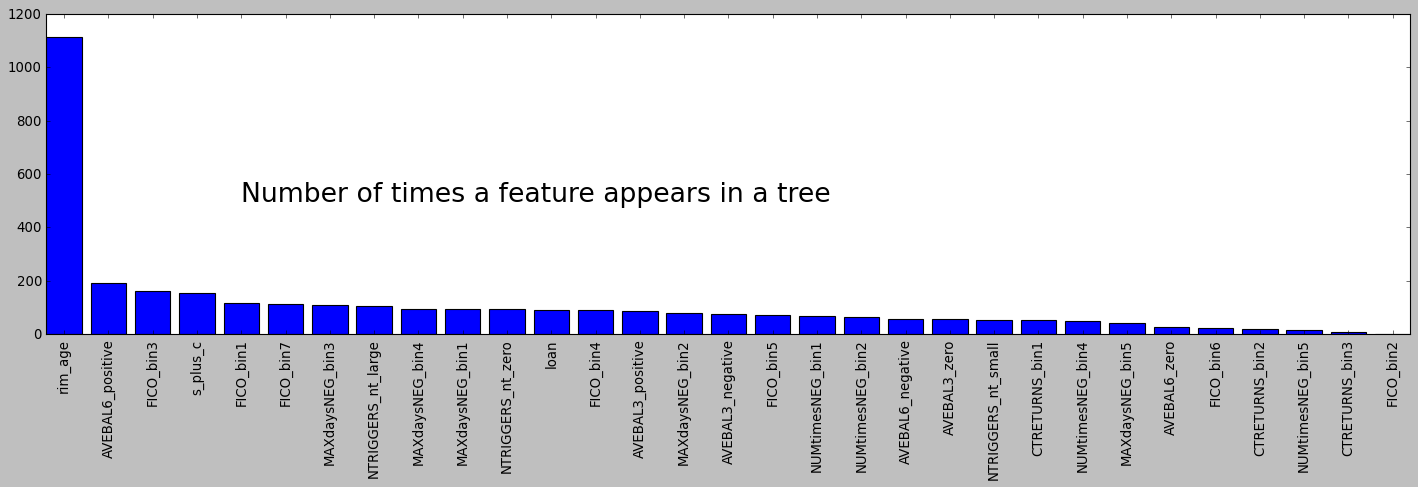

In [75]:
# "weight" is the number of times a feature appears in a tree.
feature_weights = model_rimAge.get_booster().get_score(importance_type='weight')
feature_weights = {k:v for k,v in sorted(feature_weights.items(), reverse=True, key=lambda item: item[1])}
group_data = list(feature_weights.values())
group_features = list(feature_weights.keys())
fig, ax = plt.subplots(figsize=(22,5), )
plt.style.use('classic')
plt.xticks(rotation=90)
plt.text(4, 500, "Number of times a feature appears in a tree", fontsize=24)
ax.bar(group_features, group_data)

<BarContainer object of 31 artists>

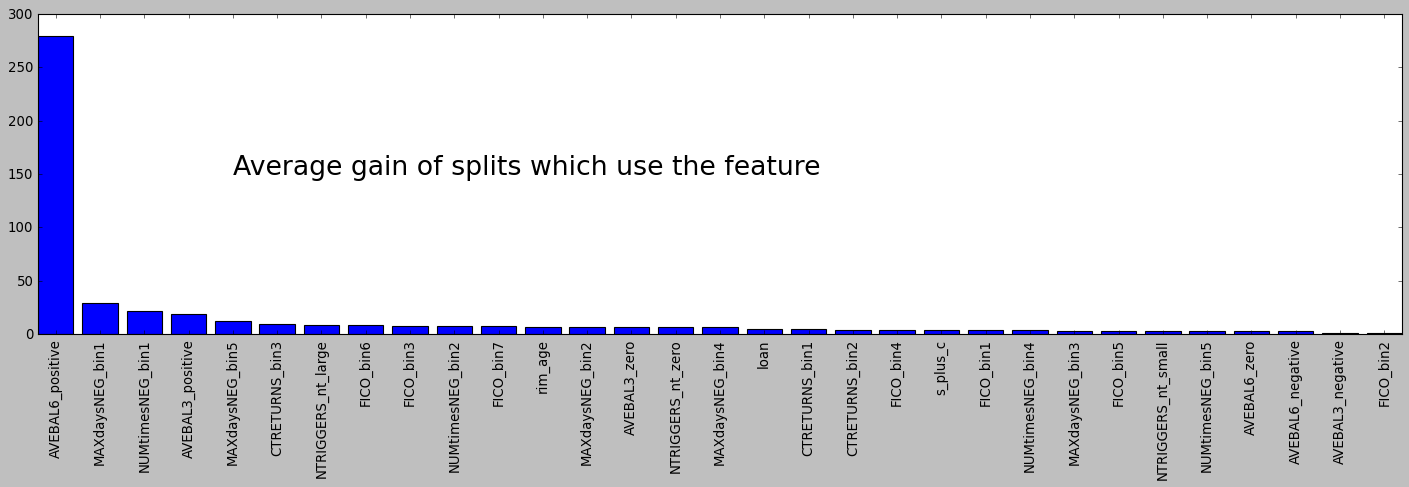

In [74]:
# "gain" is the average gain of splits which use the feature.
feature_gains = model_rimAge.get_booster().get_score(importance_type='gain')
feature_gains = {k:v for k,v in sorted(feature_gains.items(), reverse=True, key=lambda item: item[1])}
group_data = list(feature_gains.values())
group_features = list(feature_gains.keys())
fig, ax = plt.subplots(figsize=(22,5), )
plt.style.use('classic')
plt.xticks(rotation=90)
plt.text(4, 150, "Average gain of splits which use the feature", fontsize=24)
ax.bar(group_features, group_data)

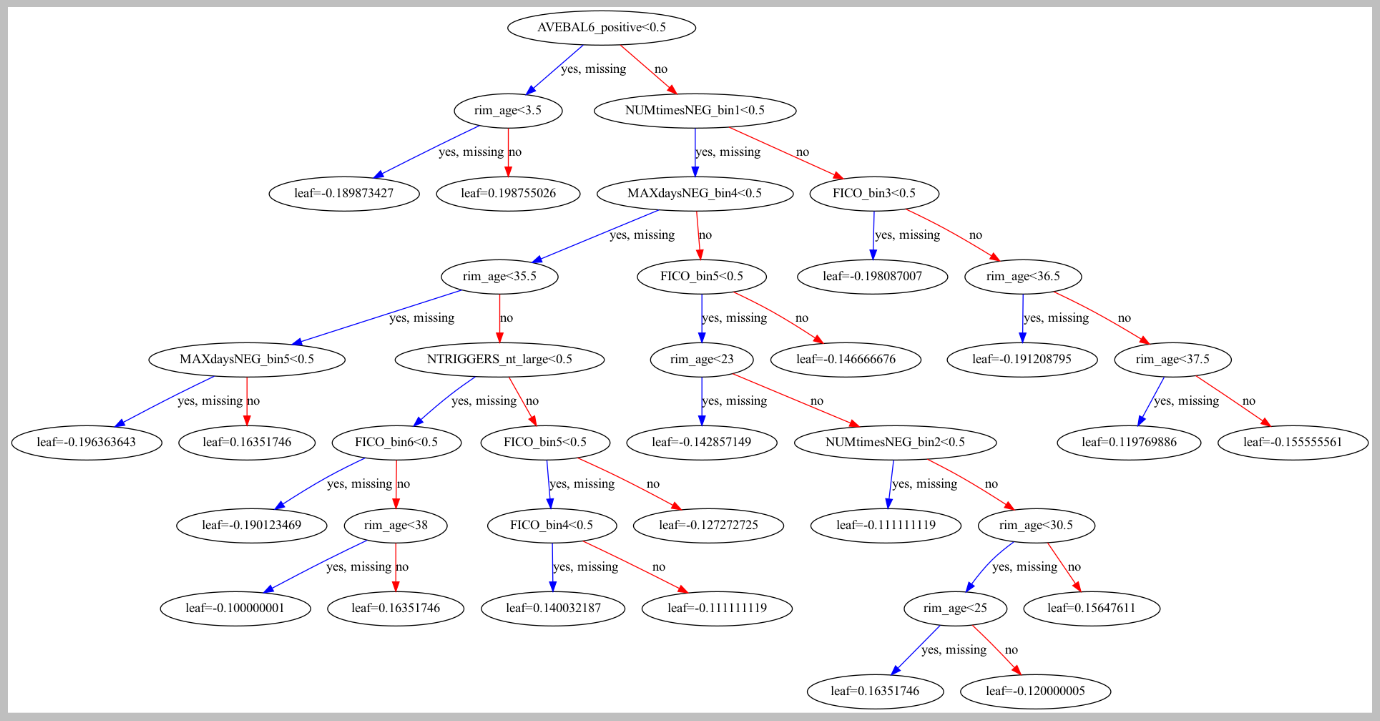

In [73]:
fig, ax = plt.subplots(figsize=(22,22))
plot_tree(model_rimAge, ax=ax)
plt.show()